In [1]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set()

In [2]:
import numpy as np
import h5py
from chainconsumer import ChainConsumer
from glob import glob
from os import path
from copy import deepcopy
from collections import OrderedDict

In [3]:
! ls -ltr ~/des/PearceMCMC/Vpeak*HOD.hdf5

-rw-r--r-- 1 swmclau2 des  690884158 Jun  8 23:29 /u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_wp_ds_rmin_2.0_HOD.hdf5
-rw-r--r-- 1 swmclau2 des 1237555483 Jul  7 19:25 /u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_wp_ds_rmin_1.0_HOD.hdf5
-rw-r--r-- 1 swmclau2 des  772087446 Jul  8 03:14 /u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_wp_ds_rmin_0.5_HOD.hdf5
-rw-r--r-- 1 swmclau2 des 1026564825 Jul  8 07:23 /u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_wp_ds_rmin_5.0_HOD.hdf5
-rw-r--r-- 1 swmclau2 des 1203449214 Jul  8 07:43 /u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_wp_ds_rmin_None_HOD.hdf5


In [4]:
fnames = []
models = ['HOD', 'HSAB', 'CAB', 'CorrAB']
for model in models:
    fn = sorted(glob('/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_*_%s.hdf5'%model)) 
    # put the None chain first instead of last 
    
    _fnames = []
    _fnames.extend(reversed(fn[:-1]) )
    _fnames.append(fn[-1])
    fn = _fnames
    
    fnames.extend(fn)

Assume all chains run with same true values, only thing that differs is the rmin. 

In [5]:
fnames

['/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_5.0_HOD.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_2.0_HOD.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_1.0_HOD.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_0.5_HOD.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_None_HOD.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_5.0_HSAB.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_2.0_HSAB.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_1.0_HSAB.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_0.5_HSAB.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_None_HSAB.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_5.0_CAB.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_2.0_CAB.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_1.0_CAB.hdf5',
 '/u/ki/swmclau2/des/PearceMCMC

In [6]:
names_to_remove = []
for fname in fnames:
    if '2.0' in fname:
        names_to_remove.append(fname)
    #pass    
for fname in names_to_remove:
    fnames.remove(fname)

In [7]:
f = h5py.File(fnames[0], 'r')

In [8]:
f.attrs.keys()

[u'chain_fixed_params',
 u'cov',
 u'dlogz',
 u'emu_cov_fname',
 u'emu_hps',
 u'emu_type',
 u'fixed_params',
 u'mcmc_type',
 u'nburn',
 u'nlive',
 u'nsteps',
 u'nwalkers',
 u'obs',
 u'param_names',
 u'seed',
 u'sim',
 u'training_file',
 u'true_cov_fname',
 u'true_data_fname']

In [9]:
#sim_info = eval(f.attrs['sim'])
sim_info = f.attrs['sim']

In [10]:
f.close()

In [11]:
param_name_dict = {'ombh2': r'$\Omega_b h^2$', 'omch2': r'$\Omega_c h^2$','w0': r'$w_0$','ns': r'$n_s$', \
                   'sigma8': r'$\sigma_8$', 'ln10As':r'$\ln 10^{10} A_s$', 'H0': r'$H_0$','Neff': r'$N_{eff}$',\
               'mean_occupation_centrals_assembias_corr1': r'$\rho_{cen}$',\
                 'mean_occupation_satellites_assembias_corr1':r'$\rho_{sat}$',\
                   'mean_occupation_centrals_assembias_param1': r'$\mathcal{A}_{cen}$',\
                 'mean_occupation_satellites_assembias_param1':r'$\mathcal{A}_{sat}$',\
                   'mean_occupation_centrals_assembias_slope1': r'$\mathcal{B}_{cen}$',\
                 'mean_occupation_satellites_assembias_slope1':r'$\mathcal{B}_{sat}$',\
                   'logM1': r'$\log(M_1)$','logM0': r'$\log(M_0)$','sigma_logM': r'$\sigma_{\log M }$',
                   'conc_gal_bias': r'$\eta$', 'alpha':r'$\alpha$',
                  'Om': r'$\Omega_m$', 'S8': r'$S_8$'}

In [12]:
bounds_dict = {'H0': (61.69472, 74.76751999999999),
 'Neff': (2.62125, 4.27875),
 'alpha': (0.7, 1.3),
 'conc_gal_bias': (0.5, 2.0),
 'sigma8': (0.65, 1.0), # TODO update
 'logM0': (12.6, 13.6),
 'logM1': (13.7, 14.7),
 'ns': (0.9278462, 0.9974495999999999),
 'ombh2': (0.02066455, 0.02371239),
 'omch2': (0.1012181, 0.13177679999999997),
 'sigma_logM': (0.05, 0.5),
 'ln10As': (3.0, 3.1),
 'w0': (-1.399921, -0.5658486),
 'Om': (0.25, 0.35),
 'S8': (0.7, 1.0),
 'mean_occupation_centrals_assembias_corr1': (-1.0, 1.0),
 'mean_occupation_satellites_assembias_corr1': (-1.0, 1.0),
 'mean_occupation_centrals_assembias_param1': (-1.0, 1.0),
 'mean_occupation_satellites_assembias_param1': (-1.0, 1.0),
 'mean_occupation_centrals_assembias_slope1': (-3.0, 3.0),
 'mean_occupation_satellites_assembias_slope1': (-3.0, 3.0)}

In [13]:
# multidark planck2
#cosmo_true_vals = np.array([0.0223, 0.1188, -1, 0.9667, 3.047, \
#                            0.6774*100, 3.046]) #darksky

h = 0.6777
#cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'Om', 'S8']
#cosmo_true_vals = np.array([0.048206*h**2, 0.307115*h**2- 0.048206*h**2,\
#                            -1, 0.9667, \
#                            h*100, 3.046, 0.8228, ]) #mdpl2
cosmo_true_vals = np.array([0.048206*h**2, 0.2589*h**2- 0.048206*h**2,\
                        -1, 0.9667, \
                        h*100, 3.046, 0.8228, 0.3089, 0.8228*np.sqrt(0.3089/0.3) ]) #mdpl2
#hod_true_vals = np.array([np.inf for p in hod_param_names])
Om = 0.3089
S8 = 0.8228*np.sqrt(0.3089/0.3)
H0=h*100

In [14]:
summary_names = ['Om','S8','H0']
true_vals_dict = dict(zip(summary_names, [Om, S8, H0]))
def_ab_val = np.inf#0.0

In [15]:
c = ChainConsumer()

In [16]:
def modify_chain(chain, param_names):
    new_pnames = ['Om', 'S8']
    h = chain[:,param_names.index('H0')]/100
    
    Omc, Omb = chain[:,param_names.index('omch2')]/(h**2), chain[:,param_names.index('ombh2')]/(h**2)
    Om = Omc+Omb
    
    S8 = chain[:,param_names.index('sigma8')]*np.sqrt(Om/0.3)

    new_chain = np.hstack([chain[:,:7], Om.reshape((-1,1)), S8.reshape((-1,1)), chain[:,7:]])
    param_names.insert(7, new_pnames[0])
    param_names.insert(8, new_pnames[1])

    return new_chain, param_names

In [17]:
true_Om, true_s8 = Om, S8

In [18]:
f = h5py.File(fname, 'r')

In [19]:
r = np.logspace(-1, 1.6, 19)
rbc = (r[1:]+r[:-1])/2.0

In [20]:
num_eff_dict = {5.0:np.sum(rbc>5.0)*2, 1.0:np.sum(rbc>1.0)*2, 0.5:np.sum(rbc>0.5)*2,\
0.1:np.sum(rbc>0.5)+np.sum(rbc>0.1)}

In [21]:
n_burn = 10000
plot_true_vals_dict = dict()
plot_bounds_dict = dict()
plot_param_names_set = set()
for fname in fnames:
    try:
        f = h5py.File(fname, 'r')
        n_walkers = f.attrs['nwalkers']

        chain = f['chain'][n_burn*n_walkers:]
        lnprob = f['lnprob'][n_burn*n_walkers:]
        keep_idxs = np.all(chain!=0.0, axis = 1)
        chain = chain[keep_idxs, :]
        lnprob = lnprob[keep_idxs]
    except IOError:
        print 'Error loading', fname
        #f.close()
        chain = np.random.randn(n_walkers, chain.shape[1])+10
        lnprob = np.ones((chain.shape[0],))*-np.inf
        #continue
    
    chain = chain.reshape((-1, n_walkers, chain.shape[1]))
    chain = chain.reshape((-1, chain.shape[2]), order = 'F')
    if chain.shape[0] == 0:
        print 'Insufficient samples in', fname
        #f.close()
        chain = np.random.randn(n_walkers, chain.shape[1])+10
        lnprob = np.zeros((chain.shape[0],))
        #continue
    
    #name = path.basename(fname).split('_')[-1].split('.')[0]
    split_fname = path.basename(fname).split('_')#[4]
    r = split_fname[-2] #[4]
    model = split_fname[-1][:-5]#[5]

    if r == "None":
        r = "0.1"
        
    if model == 'HOD':
        model = 'Std. HOD'
        
    name = r"%s $r_{min} = %s$"%(model, r)
    
    hod_param_names = []
    cosmo_param_names = []
    chain_pnames = list(f.attrs['param_names'])
    #cosmo_names = set(['ombh2', 'omch2', 'w0', 'ns', 'sigma8', 'H0', 'Neff', 'Om', 'S8'])
    chain, chain_pnames = modify_chain(chain, chain_pnames)
    summary_idxs = []
    param_names = []
    for i, pname in enumerate(chain_pnames):
        if pname in summary_names or ('mean_occupation' in pname and 'slope' not in pname):
            param_names.append(param_name_dict[pname])
            summary_idxs.append(i)
            plot_true_vals_dict[param_names[-1]] = true_vals_dict[pname] if pname in true_vals_dict else def_ab_val
            plot_bounds_dict[param_names[-1]] = bounds_dict[pname] 
            plot_param_names_set.add(param_names[-1])
    print fname
    N = 50000
    if chain.shape[0]/n_walkers > N:
        chain = chain[:N*n_walkers]
        lnprob = lnprob[:N*n_walkers]
    #print summary_idxs, param_names
    print chain.shape, chain.shape[0]/n_walkers, len(param_names)
    
    c.add_chain(chain[:, np.array(summary_idxs)], parameters=param_names,
                name = name, walkers = n_walkers, posterior = lnprob,
               num_eff_data_points = num_eff_dict[float(r)], num_free_params = len(param_names))
    f.close()


/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_5.0_HOD.hdf5
(12500000, 14) 50000 3
/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_1.0_HOD.hdf5
(12500000, 14) 50000 3
/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_0.5_HOD.hdf5
(12500000, 14) 50000 3
/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_None_HOD.hdf5
(12500000, 14) 50000 3
/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_5.0_HSAB.hdf5
(12500000, 16) 50000 5
/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_1.0_HSAB.hdf5
(12500000, 16) 50000 5
/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_0.5_HSAB.hdf5
(12500000, 16) 50000 5
/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_None_HSAB.hdf5
(12500000, 16) 50000 5
Insufficient samples in /u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_5.0_CAB.hdf5
/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_5.0_CAB.hdf5
(250, 18) 1 5
/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_1.0_CAB.hdf5
(1

In [22]:
summary_pnames = list(plot_param_names_set)
summary_true_vals = [plot_true_vals_dict[pname] for pname in summary_pnames]
summary_bounds = [plot_bounds_dict[pname] for pname in summary_pnames]

In [23]:
palettes = []
for model in models:
    if model == 'HOD':
        #palette = sns.cubehelix_palette(len(fnames), start = 2.6, rot = 0.1, gamma = 0.7)
        palette = sns.cubehelix_palette(4, start = 2.6, rot = 0.1, gamma = 2.5)#,
                                        #light = 0.6)

    elif model == 'HSAB':
        palette = sns.cubehelix_palette(4, start = 2.0, rot = 0.1, gamma = 2.5)#,
                                        #light = 0.6)
        #palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.6, gamma = 1.7)
    elif model == 'CAB':
        palette = sns.cubehelix_palette(4, start = 0.6, rot = 0.1, gamma = 2.5)# 
                                        #light = 0.6)
    elif model == 'CorrAB':
        #palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.1, gamma = 1.2)
        palette = sns.cubehelix_palette(4, start = 1.2, rot = 0.1, 
                                        gamma = 2.5)
    else:
        palette = sns.cubehelix_palette(4, start = 2.6, rot = 0.1, 
                                        gamma = 2.5)
    palettes.append(palette)
#sns.palplot(palette)

In [24]:
def color_to_hex(color):
    return np.array(color)#*255

In [25]:
colors = []
for palette in palettes:
    for p in palette:
        colors.append(color_to_hex(p))
c.configure(colors = colors, shade = False, shade_alpha=0.2,\
            shade_gradient=1.0, bar_shade=True, plot_hists=False,
            diagonal_tick_labels=False, tick_font_size=8, label_font_size=25,
            max_ticks=8)

In [26]:
summary_pnames # ugh dont know a nice way to make sure these are sorted

['$\\rho_{sat}$',
 '$\\Omega_m$',
 '$\\mathcal{A}_{sat}$',
 '$\\rho_{cen}$',
 '$\\mathcal{A}_{cen}$',
 '$H_0$',
 '$S_8$']

In [27]:
#reorder_idxs = [3, 1, 0, 4, 2]
#reorder_idxs = [2, 6, 5, 4, 3, 1, 0]
reorder_idxs = [1, 6, 5, 4, 2, 3,0]

summary_pnames = [summary_pnames[i] for i in reorder_idxs]
summary_true_vals = [summary_true_vals[i] for i in reorder_idxs]
summary_bounds = [summary_bounds[i] for i in reorder_idxs]

In [28]:
from os.path import basename
split_fname = basename(fnames[-1]).split('_')
mock_name = split_fname[0]
#model_name = split_fname[-1].split('.')[0]

if mock_name == 'HOD':
    mock_name = 'Std. HOD'
    
elif mock_name == 'VpeakSHAM':
    mock_name = 'SHAM'
elif mock_name == 'UniverseMachine':
    mock_name = 'UM'
    
#if model_name == 'HOD':
#    model_name = 'Std. HOD'

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


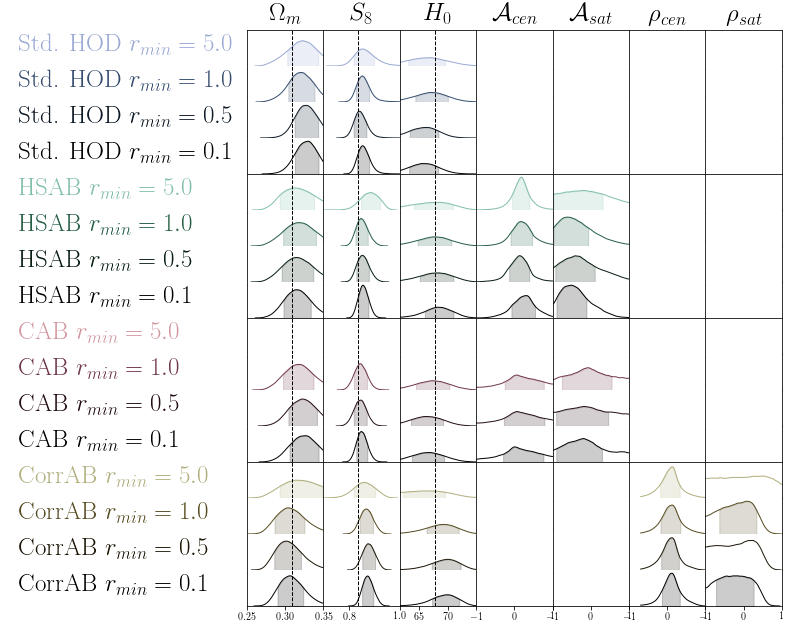

In [29]:
fig = c.plotter.plot_summary(parameters = summary_pnames,\
                             truth=summary_true_vals, extents=summary_bounds,\
                             figsize=1.0, errorbar=False) 
#fig.suptitle(mock_name) # + galtype
fig.savefig('%s_summary.pdf'%mock_name, format='pdf')
fig.show()

In [30]:
models = ['HOD', 'HSAB', 'CAB', 'CorrAB']
deltas = np.zeros((4,len(models),2))
for i, model in enumerate(models):
    rmins = []

    for chain in c.chains:
        if chain.name[:len(model)] != model:
            continue
        for k, param in enumerate([r'$S_8$', r'$\Omega_m$']):
            summary = c.analysis.get_parameter_summary(chain, param)
            delta = summary[2]-summary[0]
            deltas[len(rmins), i, k] = delta
        rmin = chain.name.split()[-1][:-1]
        rmins.append(float(rmin))
        
        print rmin, delta
    print 


5.0 0.04493619889469652
1.0 0.04287907106080374
0.5 0.04139417845732246
0.1 0.035723781982879066



TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [ ]:
import seaborn as sns
sns.set_palette('deep')
current_palette = sns.color_palette()
sns.palplot(current_palette)
model_color_map = {'Std. HOD': (current_palette[0], "GnBu_d"),
                    'HSAB': (current_palette[1], "YlGn_d"),
                   'SHAM': (current_palette[2], "OrRd_d"),
                   'CAB': (current_palette[3], "RdPu_d"),
                   'CorrAB': (current_palette[4], "YlOrBr_d"),
                    'Halos': (current_palette[5], 'PuBu_d')} # add CMAPs too

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (10,4))
models = ['Std. HOD', 'HSAB', 'CAB', 'CorrAB']

for k,(ax, param, true_param) in enumerate(zip(axes,[r'$S_8$', r'$\Omega_m$'],
                                          [true_s8, true_Om])):
    for i, model  in enumerate(models):
        ax.plot(np.array(rmins), deltas[:,i,k]/true_param,
                color = model_color_map[model][0],
               label = model)
        ax.set_ylabel(r'$\Delta %s/%s$'%(param[1:-1],param[1:-1]))

    ax.set_xscale('log')
    ax.set_xlabel(r'$r_{min}$ [Mpc/h]')
axes[1].legend(loc='best', frameon=False)

In [ ]:
c.chains[0].name

In [ ]:
bic = c.comparison.bic()

for chain_name, b in zip(c.chains, bic):
    print chain_name.name,'\t', b

In [ ]:
c.diagnostic.gelman_rubin()